### Simple FD + implicit Euler

$$
u_t -u_{xx} = 0 \\
u(0,t) = 0 \\
u(L,t) = 0 \\
u(x,0) = 6\sin(\frac{\pi x}{L})
$$

In [17]:
import numpy as np 
from scipy.sparse import csr_matrix, lil_matrix, vstack, hstack, save_npz, load_npz, block_diag, diags_array
from cyclic_reduction_v8 import scalar_cyclic_reduction, cyclic_redcution_parallel
from scipy.sparse.linalg import inv, spsolve, splu
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import csv
import os

In [18]:
# Intervals
x0, xf = 0, 1
t0, tf = 0, 1

# Number of discretization points
M = 100
N = 100

# Discretization steps
dx = (xf-x0)/M
dt = (tf-t0)/N

# Grid
x = np.linspace(x0, xf, M+1)
t = np.linspace(t0, tf, N+1)

k = 1 # Thermal diffusivity constant

def boundary_condition_left(t):
    return t*0

def boundary_condition_right(t):
    return t*0

def initail_condition(x):
    return 6*np.sin(np.pi*x/xf)

# Solution
u = [initail_condition(x)]

# Implicit Euler scheme
for n in range(1, N+1):
    # Linear system
    A = np.eye(M-1) - (k*dt/dx**2)*(np.eye(M-1, k=1) - 2*np.eye(M-1) + np.eye(M-1, k=-1))
    u_n = u[n-1][1:-1]

    # Boundary conditions
    u_n[0] += k*dt/dx**2 * boundary_condition_left(t[n])
    u_n[-1] += k*dt/dx**2 * boundary_condition_right(t[n])

    u_new = np.linalg.solve(A,u_n)
    u_new = np.insert(u_new,0,boundary_condition_left(t[n]))
    u_new = np.append(u_new, boundary_condition_right(t[n]))
    u.append(u_new)

def animation_frame(i):
    plt.cla()
    plt.plot(x, u[i])
    plt.xlim(0,xf)
    plt.ylim(0,u[0].max()+1)

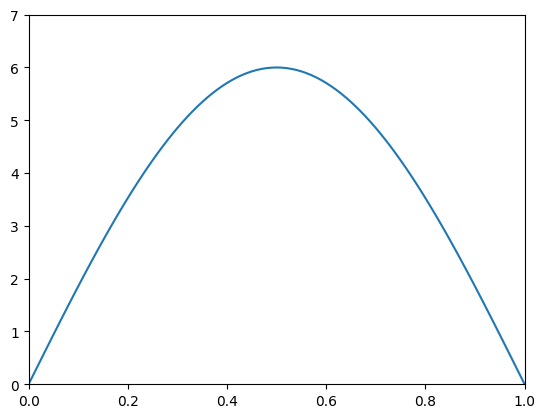

In [19]:
fig = plt.figure()
ani = FuncAnimation(fig, animation_frame,frames=N+1, interval=100)

HTML(ani.to_jshtml())

#### Solving the 1D heat equation, using central FD in space and discontinous Galerkin FE in time
$$
u_t - \Delta u = 0 \quad , \quad \text{for} \quad x \in [0,L], t \in [0,T]
$$
Discretization chosen to yield final solution of the form
$$
u_f = [u_{0}^{0,-} \dots u_{M}^{0,-} u_{0}^{0,+} \dots u_{M}^{0,+} \dots \dots u_{0}^{N,-} \dots u_{M}^{N,-} u_{0}^{N,+} \dots u_{M}^{N,+}]
$$
With initial condition $u^{0,-} = u_{0}^{0,-} \dots u_{m}^{0,-} = u(x,0) = 6\sin(\frac{\pi x}{L})$ 

and boundary conditions $u_{0}^{n,-} = u_{0}^{n,+} = u(0,t) = 0 =  u(L,t) = u_{M}^{n,+} = u_{M}^{n,+} \quad \forall n $

In [20]:
# Intervals
x0, xf = 0, 1
t0, tf = 0, 0.5

# Number of discretization points
M = 200 # Spatial segments/elements or M+1 nodes
N = 200 # Temporal segments/elements or N+1 nodes

# Discretization steps
dx = (xf-x0)/M
dt = (tf-t0)/N
x = np.linspace(x0, xf, M+1)
t = np.linspace(t0, tf, N+1)
t_p = np.linspace(t0, tf, 2*N+1)

k = 1 # Thermal diffusivity constant
alpha = k/(dx**2)

# Initial condition
def initial_condition(x):
    return 6*np.sin(np.pi*x/xf)

# Boundary conditions
def initial_cond_t(t):
    return t*0

# Determine matrix size:
# The solution is a 2D grid. The grid is discretized in space and time with N+1 temporal nodes and M+1 spatial nodes.
# Each temporal element contains 2 temporal nodes. For each temporal node, there are M spatial nodes. 
# Due to boundary conditions, the first and last spatial nodes will be considered in the RHS vector f.
# Due to the initial condition, the first temporal node will be considered in the RHS vector f.
# Therefore, the matrix size will be (N*2-1)*(M-1) x (N*2-1)*(M-1) 

block_size = M-1
time_steps = 2*N + 1
matrix_size = time_steps*block_size

# RHS vector
f = csr_matrix((matrix_size,1))
f[:block_size] += initial_condition(x[1:-1]).reshape(-1,1) 

placeholder_A = csr_matrix((block_size,block_size))
placeholder_A.setdiag(np.ones(block_size)*(-2))
placeholder_A.setdiag(np.ones(block_size-1),1)
placeholder_A.setdiag(np.ones(block_size-1),-1)

block_identity = csr_matrix((block_size,block_size))
block_identity.setdiag(np.ones(block_size))

main_diagonal_block = -(dt*alpha)/2*placeholder_A
upper_diagonal_block = block_identity - (dt*alpha)/2*placeholder_A
lower_diagonal_block = - block_identity 

def build_matrix():
    mat = csr_matrix((matrix_size,matrix_size))
    for i in tqdm(range(time_steps)):
        if i == 0:
            mat[i*block_size:(i+1)*block_size,i*block_size:(i+1)*block_size] = main_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i+1)*block_size:(i+2)*block_size] = upper_diagonal_block
        elif i == time_steps-1:
            mat[i*block_size:(i+1)*block_size,i*block_size:(i+1)*block_size] = main_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i-1)*block_size:i*block_size] = lower_diagonal_block
        else:
            mat[i*block_size:(i+1)*block_size,i*block_size:(i+1)*block_size] = main_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i-1)*block_size:i*block_size] = lower_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i+1)*block_size:(i+2)*block_size] = upper_diagonal_block
    return mat

#Ns = [17,33,129,257,513,1025,2049,4097,8193]
A = build_matrix()
print("Shape A: ", A.shape, "Shape f: ", f.shape)
print("N: ", int(A.shape[0]/block_size))

c:\Users\tinus\OneDrive\Desktop\Mastah\La Code\.venv\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
  0%|          | 0/401 [00:00<?, ?it/s]c:\Users\tinus\OneDrive\Desktop\Mastah\La Code\.venv\Lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 401/401 [00:06<00:00, 61.09it/s]

Shape A:  (79799, 79799) Shape f:  (79799, 1)
N:  401


In [21]:
sol = spsolve(A,f)
sol_mat = sol.reshape(time_steps,block_size)
# Add boundary conditions
sol_mat = np.hstack((boundary_condition_left(t_p).reshape(-1,1),sol_mat,boundary_condition_right(t_p).reshape(-1,1)))
# Add initial condition
sol_mat = np.vstack((initial_condition(x),sol_mat))

### Exact solution

In [22]:
# Grid
x = np.linspace(x0, xf, M+1)
t = np.linspace(t0, tf, N+1)
#t = np.linspace(t0, tf, 2*N+2)


k = 1 # Thermal diffusivity constant

def exact_solution(x,t):
    return 6*np.sin(np.pi*x/xf)*np.exp(-k*(np.pi/xf)**2*t)

true_sol = np.zeros((len(t),len(x)))

for time in range(len(t)):
    for space in range(len(x)):
        true_sol[time,space] = exact_solution(x[space],t[time])

print(true_sol.shape)
print(sol_mat.shape)

(201, 201)
(402, 201)


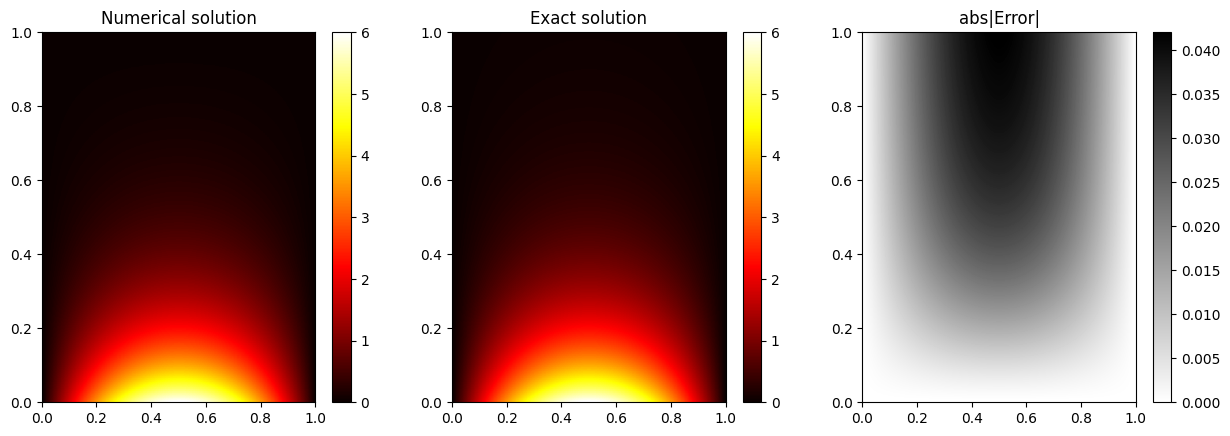

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
true_display = true_sol[-1::-1]
sol_display = sol_mat[-1::-1][1::2]
#sol_display = sol_mat[-1::-1]

ax1.set_title("Numerical solution")
ax2.set_title("Exact solution")
ax3.set_title("abs|Error|")
im1 = plt.colorbar(ax1.imshow(sol_display, aspect='auto',cmap='hot', extent=[0,1,0,1]), ax=ax1)
im2 = plt.colorbar(ax2.imshow(true_display, aspect='auto',cmap='hot', extent=[0,1,0,1]), ax=ax2)
#im3 = plt.colorbar(ax3.imshow(sol_display-true_display, aspect='auto',cmap='hot', extent=[0,1,0,1],vmin=0,vmax=6), ax=ax3)
im3 = plt.colorbar(ax3.imshow(np.abs(sol_display-true_display), aspect='auto',cmap='binary', extent=[0,1,0,1]), ax=ax3)

# Make space for title
plt.subplots_adjust(top=0.85)
plt.show()

In [24]:
print(np.linalg.norm(sol_display-true_display,ord='fro'))

4.3413018421212906


In [25]:
# Intervals
x0, xf = 0, 1
t0, tf = 0, 0.5

# Number of discretization points
M = 5 # Spatial segments/elements or M+1 nodes
N = 4 # Temporal segments/elements or N+1 nodes

# Discretization steps
dx = (xf-x0)/M
dt = (tf-t0)/N
x = np.linspace(x0, xf, M+1)
t = np.linspace(t0, tf, N+1)
t_p = np.linspace(t0, tf, 2*N+1)

k = 1 # Thermal diffusivity constant
alpha = k/(dx**2)

# Initial condition
def initial_condition(x):
    return 6*np.sin(np.pi*x/xf)

# Boundary conditions
def initial_cond_t(t):
    return t*0

# Determine matrix size:
# The solution is a 2D grid. The grid is discretized in space and time with N+1 temporal nodes and M+1 spatial nodes.
# Each temporal element contains 2 temporal nodes. For each temporal node, there are M spatial nodes. 
# Due to boundary conditions, the first and last spatial nodes will be considered in the RHS vector f.
# Due to the initial condition, the first temporal node will be considered in the RHS vector f.
# Therefore, the matrix size will be (N*2-1)*(M-1) x (N*2-1)*(M-1) 

block_size = M-1
time_steps = 2*N + 1
matrix_size = time_steps*block_size

# RHS vector
f = csr_matrix((matrix_size,1))
f[:block_size] += initial_condition(x[1:-1]).reshape(-1,1)

placeholder_A = csr_matrix((block_size,block_size))
placeholder_A.setdiag(np.ones(block_size)*(-2))
placeholder_A.setdiag(np.ones(block_size-1),1)
placeholder_A.setdiag(np.ones(block_size-1),-1)

block_identity = csr_matrix((block_size,block_size))
block_identity.setdiag(np.ones(block_size))

main_diagonal_block = -(dt*alpha)/2*placeholder_A
upper_diagonal_block = block_identity - (dt*alpha)/2*placeholder_A
lower_diagonal_block = - block_identity 

def build_matrix():
    mat = csr_matrix((matrix_size,matrix_size))
    for i in range(time_steps):
        if i == 0:
            mat[i*block_size:(i+1)*block_size,i*block_size:(i+1)*block_size] = main_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i+1)*block_size:(i+2)*block_size] = upper_diagonal_block
        elif i == time_steps-1:
            mat[i*block_size:(i+1)*block_size,i*block_size:(i+1)*block_size] = main_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i-1)*block_size:i*block_size] = lower_diagonal_block
        else:
            mat[i*block_size:(i+1)*block_size,i*block_size:(i+1)*block_size] = main_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i-1)*block_size:i*block_size] = lower_diagonal_block
            mat[i*block_size:(i+1)*block_size,(i+1)*block_size:(i+2)*block_size] = upper_diagonal_block
    return mat

A = build_matrix()
print("Shape A: ", A.shape, "Shape f: ", f.shape)
print("N: ", int(A.shape[0]/block_size))

Shape A:  (36, 36) Shape f:  (36, 1)
N:  9


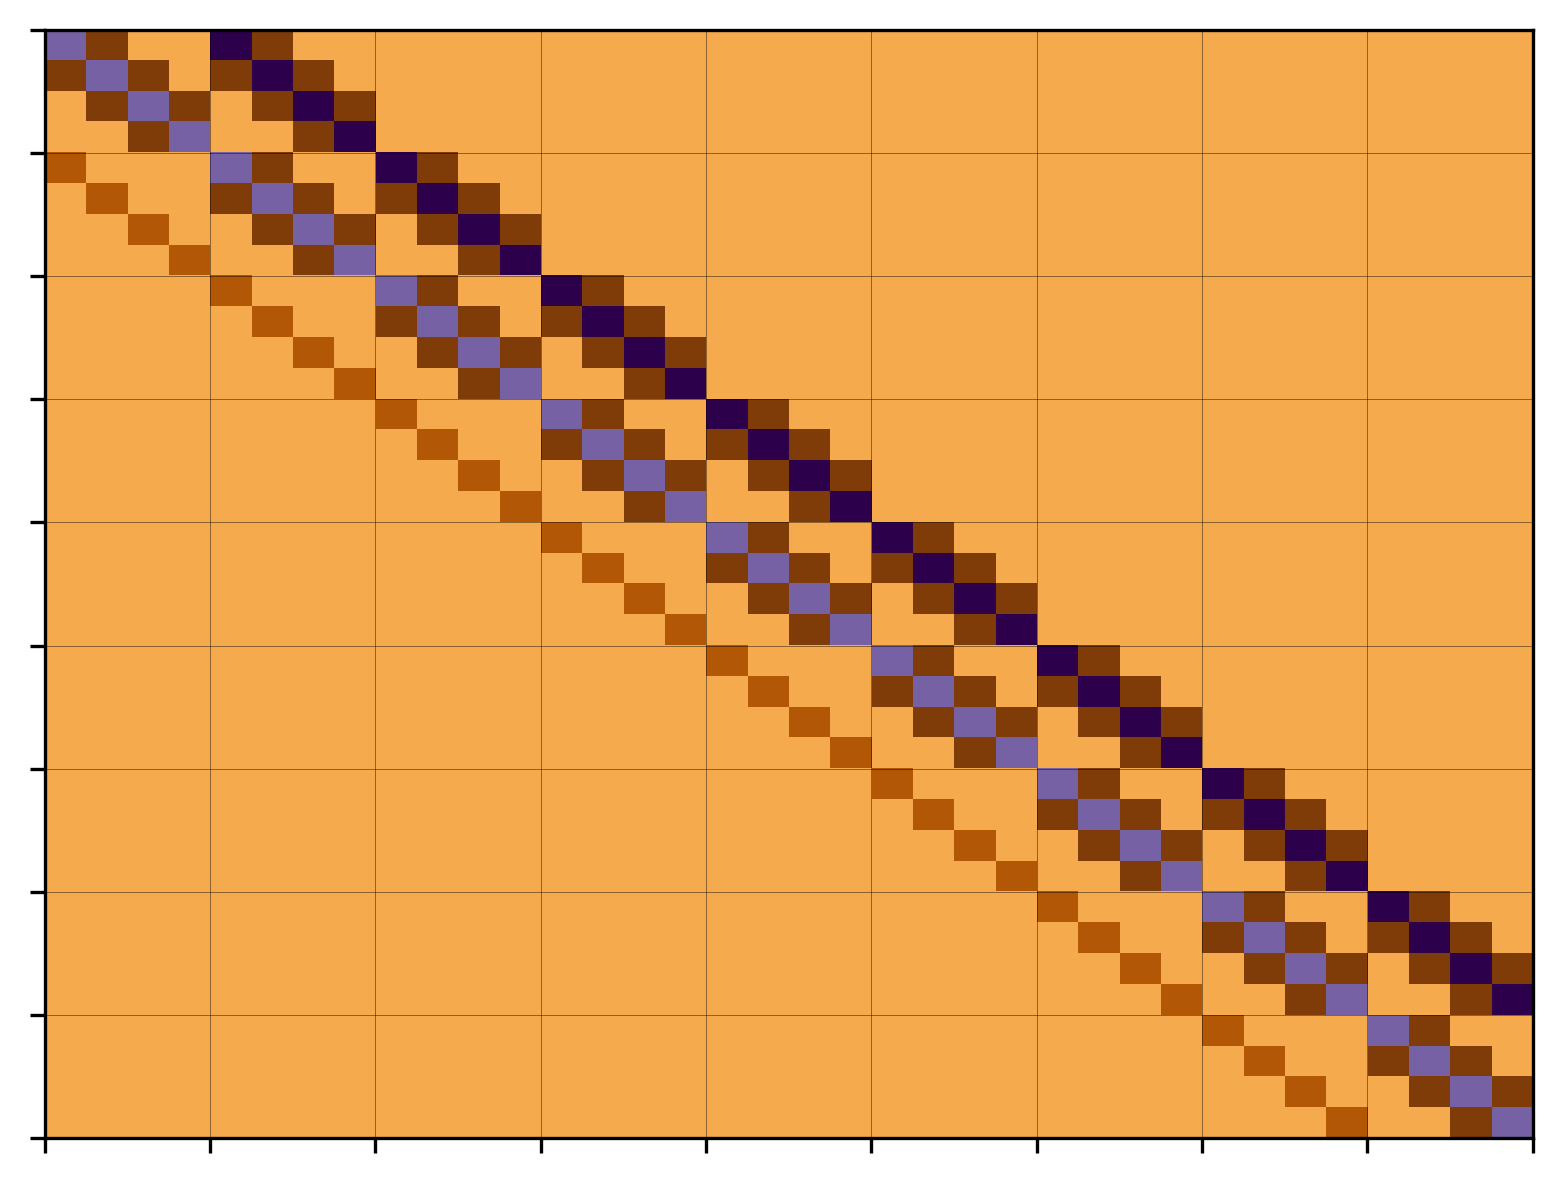

In [26]:
plt.imshow(A.toarray(),cmap='PuOr',aspect='auto',vmin = A.min(),vmax=A.max(),extent=[0,1,0,1])
#plt.imshow(A.toarray(),cmap='hot',aspect='auto',vmin = A.min(),vmax=A.max(),extent=[0,1,0,1])
#plt.title(f"Block tridiagonal structure, shape: ({block_size}x{time_steps})x({block_size}x{time_steps})")
arr1 = np.linspace(0,1,2*N+2)
arr2 = np.linspace(0,1,2*N+2)
plt.yticks(arr1,labels="")
plt.xticks(arr2,labels="")
plt.grid(color="black",linewidth=0.2,alpha=0.5)
#plt.colorbar()
plt.gcf().set_dpi(300)
plt.show()

In [27]:
one_proc_time = []
two_proc_time = []
four_proc_time = []
eight_proc_time = []
sixteen_proc_time = []
problem_sizes = set()

filename = "results/runtimes.csv"

# Open and read the CSV file
with open(filename, mode="r", newline="") as file:
    reader = csv.reader(file)  # Initialize CSV reader
    header = next(reader)  # Read the header row
    print("Header:", header)
    
    # Read and print each row
    for row in reader:
        if int(row[1]) == 1:
            one_proc_time.append(float(row[2]))
        elif int(row[1]) == 2:
            two_proc_time.append(float(row[2]))
        elif int(row[1]) == 4:
            four_proc_time.append(float(row[2]))
        elif int(row[1]) == 8:
            eight_proc_time.append(float(row[2]))
        elif int(row[1]) == 16:
            sixteen_proc_time.append(float(row[2]))
        problem_sizes.add(int(row[0]))
problem_sizes = list(problem_sizes)

Header: ['problemSize', 'nProcessors', 'BCRSolveTime', 'spluSolveTime', 'Error']


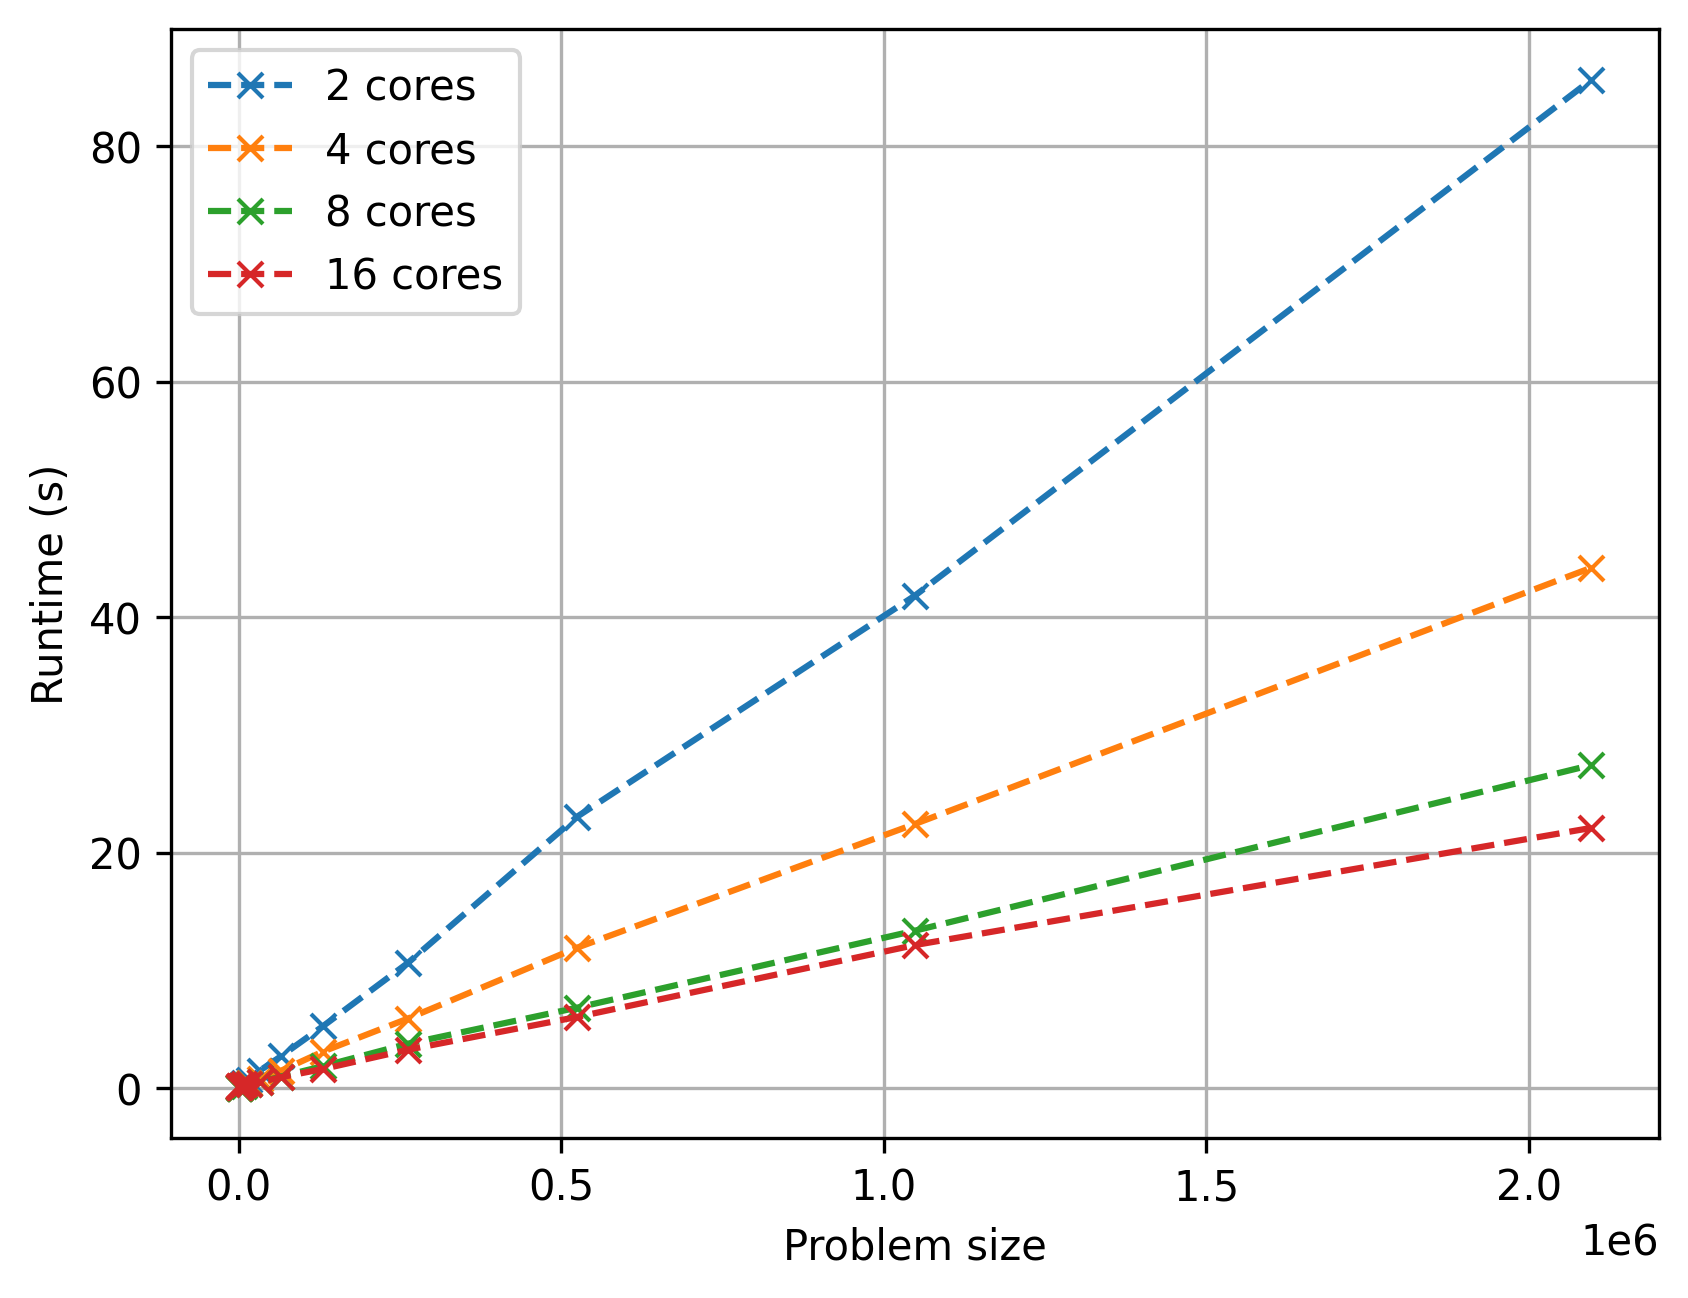

In [32]:
#plt.plot(problem_sizes,one_proc_time,linestyle = "--", marker = "x", label="1 core")
plt.plot(problem_sizes,two_proc_time,linestyle = "--", marker = "x", label="2 cores")
plt.plot(problem_sizes,four_proc_time,linestyle = "--", marker = "x", label="4 cores")
plt.plot(problem_sizes,eight_proc_time,linestyle = "--", marker = "x", label="8 cores")
plt.plot(problem_sizes,sixteen_proc_time,linestyle = "--", marker = "x", label="16 cores")
plt.xlabel("Problem size")
plt.ylabel("Runtime (s)")
plt.grid(True)
plt.gcf().set_dpi(300)
plt.legend(loc="upper left")

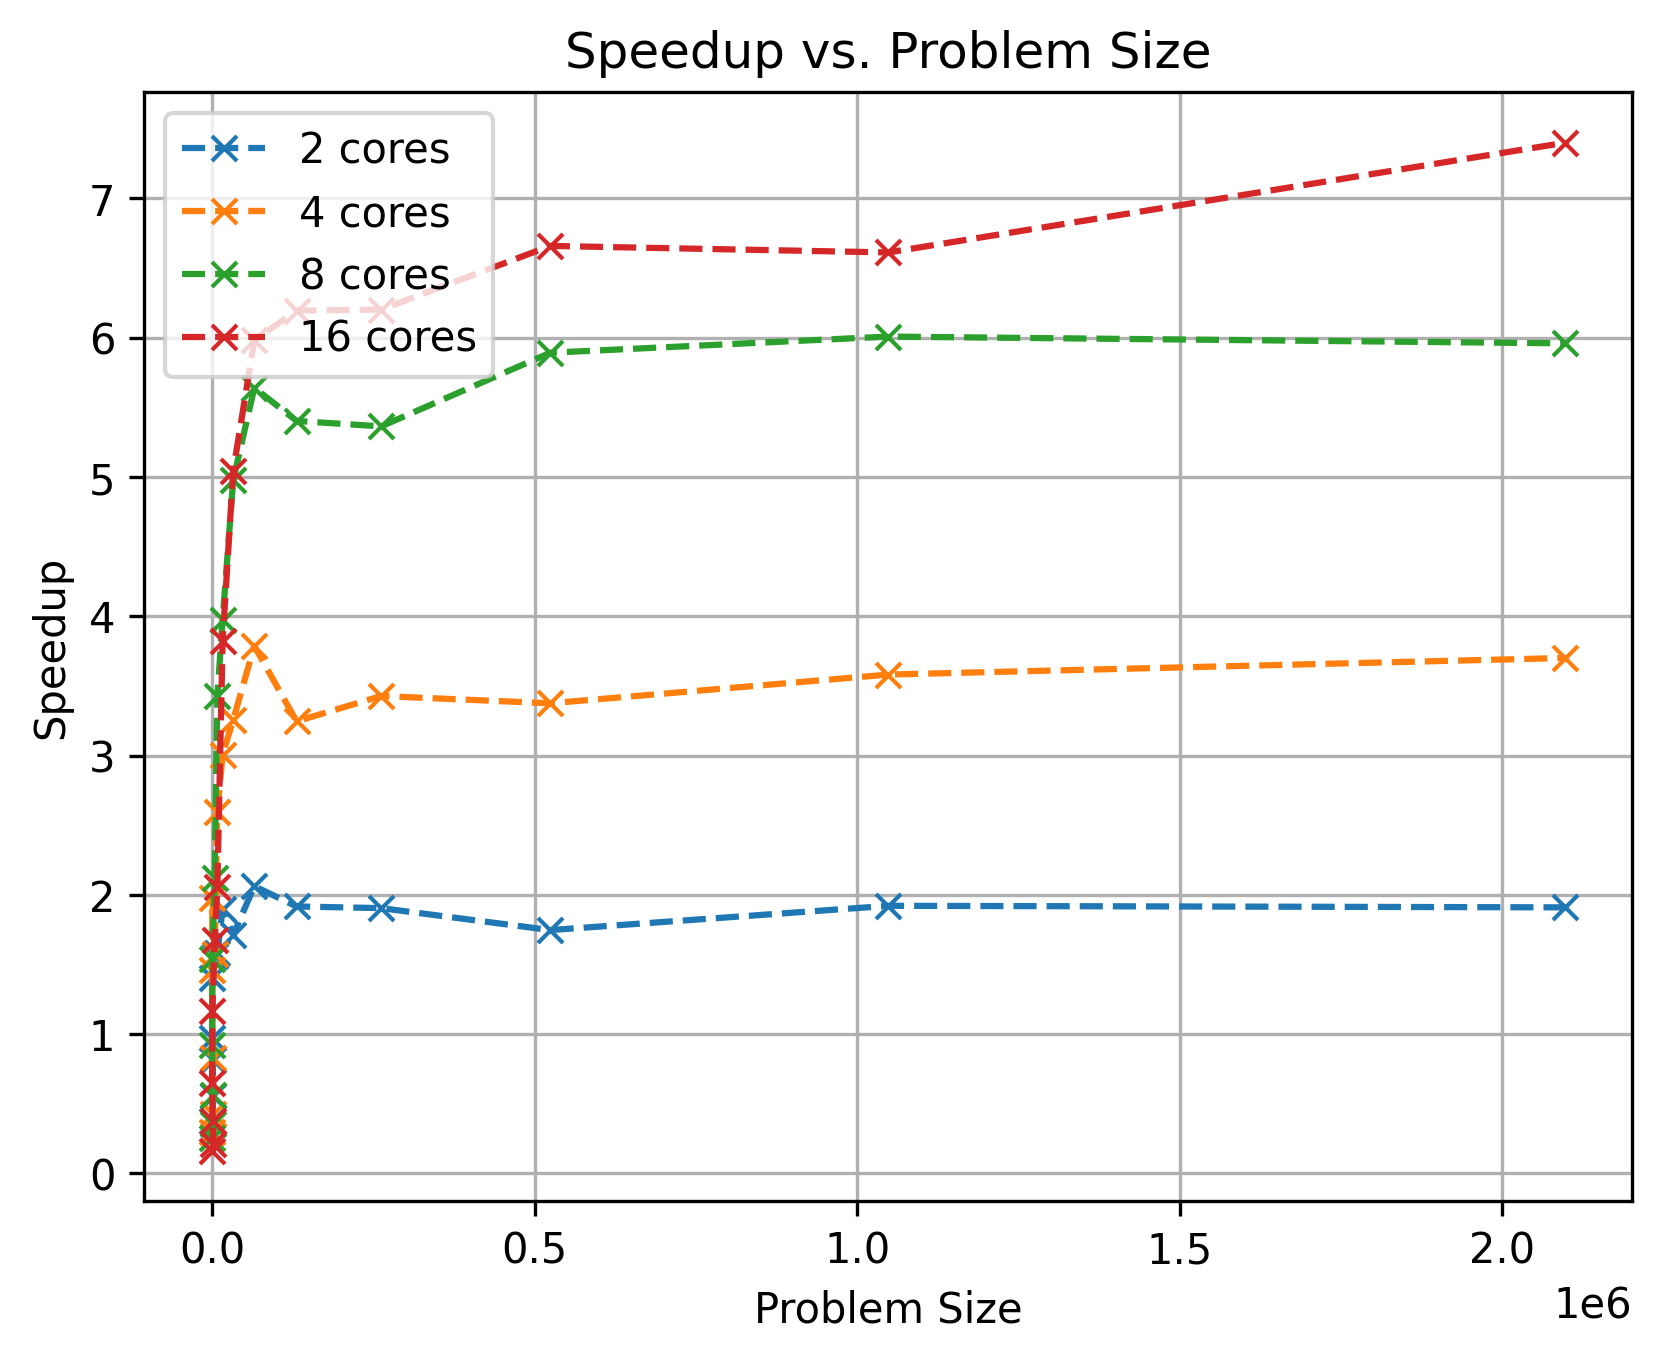

In [33]:
# Calculate speedup for each processor count
speedup_two = [one_proc / two_proc for one_proc, two_proc in zip(one_proc_time, two_proc_time)]
speedup_four = [one_proc / four_proc for one_proc, four_proc in zip(one_proc_time, four_proc_time)]
speedup_eight = [one_proc / eight_proc for one_proc, eight_proc in zip(one_proc_time, eight_proc_time)]
speedup_sixteen = [one_proc / sixteen_proc for one_proc, sixteen_proc in zip(one_proc_time, sixteen_proc_time)]

# Plot speedup
plt.plot(problem_sizes, speedup_two, linestyle="--", marker="x", label="2 cores")
plt.plot(problem_sizes, speedup_four, linestyle="--", marker="x", label="4 cores")
plt.plot(problem_sizes, speedup_eight, linestyle="--", marker="x", label="8 cores")
plt.plot(problem_sizes, speedup_sixteen, linestyle="--", marker="x", label="16 cores")

plt.xlabel("Problem Size")
plt.ylabel("Speedup")
plt.title("Speedup vs. Problem Size")
plt.legend(loc="upper left")
plt.grid(True)
plt.gcf().set_dpi(300)
plt.show()


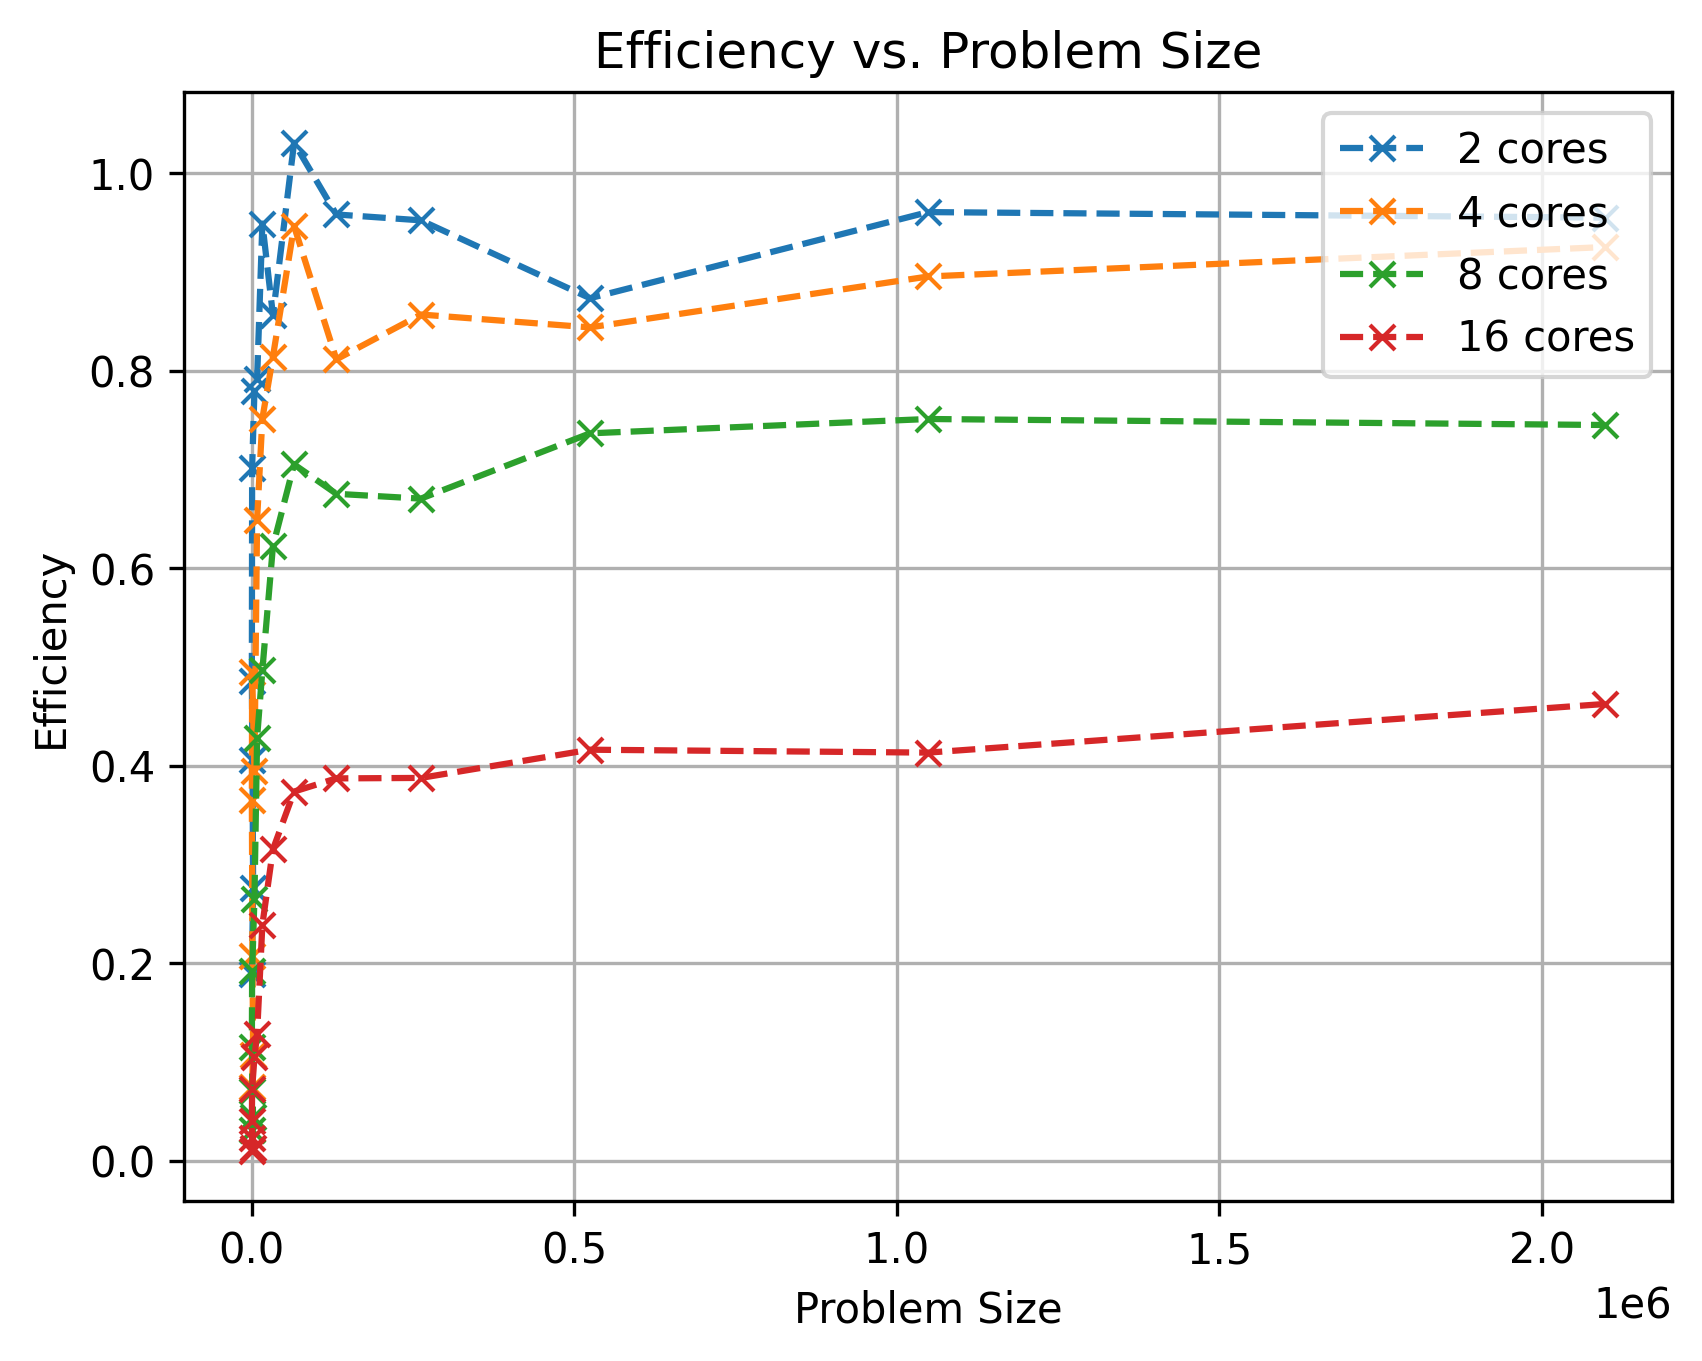

In [34]:
# Calculate efficiency for each processor count
efficiency_two = [s / 2 for s in speedup_two]
efficiency_four = [s / 4 for s in speedup_four]
efficiency_eight = [s / 8 for s in speedup_eight]
efficiency_sixteen = [s / 16 for s in speedup_sixteen]

# Plot efficiency
plt.plot(problem_sizes, efficiency_two, linestyle="--", marker="x", label="2 cores")
plt.plot(problem_sizes, efficiency_four, linestyle="--", marker="x", label="4 cores")
plt.plot(problem_sizes, efficiency_eight, linestyle="--", marker="x", label="8 cores")
plt.plot(problem_sizes, efficiency_sixteen, linestyle="--", marker="x", label="16 cores")

plt.xlabel("Problem Size")
plt.ylabel("Efficiency")
plt.title("Efficiency vs. Problem Size")
plt.legend(loc="upper right")
plt.grid(True)
plt.gcf().set_dpi(300)
plt.show()

In [31]:
print("Fraction of time spent on sequential code:")
print(0.06493020057678223/1.7669401168823242*100) # 4000
print(0.04253721237182617/1.6464273929595947*100) # 8000
print(0.0344090461730957/2.389951705932617*100) # 32000
print(0.04599785804748535/9.155103206634521*100) # 260000

Fraction of time spent on sequential code:
3.674725586702296
2.5836069391047896
1.4397381372887808
0.5024286128653538
